<a href="https://colab.research.google.com/github/LauJohansson/ImageSegmentation_lung_CT/blob/master/ImageSegmentation_of_lung_CT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from skimage.io import imread
import os
from skimage.transform import resize
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
#!pip install torchsummary
from torchsummary import summary
import torch.optim as optim
from time import time
import zipfile
from google.colab import drive
!pip install torchviz
from torchviz import make_dot

import datetime
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
import random
#annotation_name="l0.png"
#annotation_name="l1.png"
#annotation_name="l2.png"
#annotation_name="l3.png"

annotation_names=["l0.png","l1.png","l2.png","l3.png"]
name_choose=0 #0 er annotation l0 
#name_choose="random"

In [3]:
#if not os.path.exists('./LIDC_crops'):
 #   import gdown
  #  url = 'https://drive.google.com/uc?id=14BECMfFtECu6dbaqFXw6cmASVYc2JREM'
   # gdown.download(url, './LIDC_crops.zip', quiet=False)
    #!unzip ./LIDC_crops.zip > /dev/null

In [4]:
if not os.path.exists('./LIDC_crops'):
    import gdown
    url = 'https://drive.google.com/uc?id=1igqvFwNvx9yea-v6a-UgJSnR_KkfZ7Cx'
    gdown.download(url, './LIDC_DLCV_version.zip', quiet=False)
    !unzip ./LIDC_DLCV_version.zip > /dev/null

## Train data

In [8]:
#Save filnames
for root, dirs, files in os.walk('./LIDC_crops/LIDC_DLCV_version'):
    if root.endswith('/train/images'):
        filnavne_billeder=files
    if root.endswith('/train/lesions'):
        filnavne_lesions=files

#Sort names
filnavne_billeder_sort=sorted(filnavne_billeder)
filnavne_lesions_sort=sorted(filnavne_lesions)

billeder_root='./LIDC_crops/LIDC_DLCV_version/train/images'
lesions_root='./LIDC_crops/LIDC_DLCV_version/train/lesions'

images_train=[]
lesions_train=[]

#Save images
for i in range(len(filnavne_billeder_sort)):
          images_train.append(imread(os.path.join(billeder_root, filnavne_billeder_sort[i])))


#Save annotations
r=random.randint(0,4)
for i in range(len(filnavne_lesions_sort)):
          if name_choose=="random":
            if annotation_names[r] in filnavne_lesions_sort[i]:
              lesions_train.append(imread(os.path.join(lesions_root, filnavne_lesions_sort[i])))
              r=random.randint(0,4)

          elif annotation_names[name_choose] in filnavne_lesions_sort[i]:
            lesions_train.append(imread(os.path.join(lesions_root, filnavne_lesions_sort[i])))

Resizing the images.

In [9]:
size = (128, 128)
X_train = [resize(x, size, mode='constant', anti_aliasing=True) for x in images_train]
Y_train = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in lesions_train]

X_train = np.array(X_train, np.float32)
Y_train = np.array(Y_train, np.float32)
print('Loaded %d images' % len(X_train))

Loaded 8843 images


Draw some of the images to ensure they are correct...

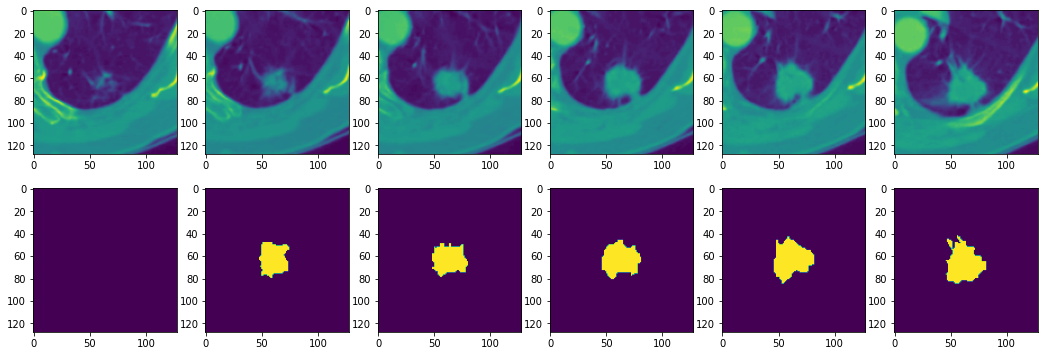

In [10]:
plt.rcParams['figure.figsize'] = [18, 6]

for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.imshow(X_train[i])

    plt.subplot(2, 6, i+7)
    plt.imshow(Y_train[i])
plt.show();

## Test data

In [11]:
#Save file names
for root, dirs, files in os.walk('./LIDC_crops/LIDC_DLCV_version'):
    if root.endswith('/test/images'):
        filnavne_billeder=files
    if root.endswith('/test/lesions'):
        filnavne_lesions=files

#Sort names
filnavne_billeder_sort=sorted(filnavne_billeder)
filnavne_lesions_sort=sorted(filnavne_lesions)

billeder_root='./LIDC_crops/LIDC_DLCV_version/test/images'
lesions_root='./LIDC_crops/LIDC_DLCV_version/test/lesions'

images_test=[]
lesions_test=[]

#Save images
for i in range(len(filnavne_billeder_sort)):
          images_test.append(imread(os.path.join(billeder_root, filnavne_billeder_sort[i])))


#Save the annotations
r=random.randint(0,4)
for i in range(len(filnavne_lesions_sort)):
          if name_choose=="random":
            if annotation_names[r] in filnavne_lesions_sort[i]:
              lesions_test.append(imread(os.path.join(lesions_root, filnavne_lesions_sort[i])))
              r=random.randint(0,4)

          elif annotation_names[name_choose] in filnavne_lesions_sort[i]:
            lesions_test.append(imread(os.path.join(lesions_root, filnavne_lesions_sort[i])))

Resize the images.

In [12]:
size = (128, 128)
X_test = [resize(x, size, mode='constant', anti_aliasing=True) for x in images_test]
Y_test = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in lesions_test]

X_test = np.array(X_test, np.float32)
Y_test = np.array(Y_test, np.float32)
print('Loaded %d images' % len(X_test))

Loaded 1980 images


Draw some of the images to ensure they are correct...

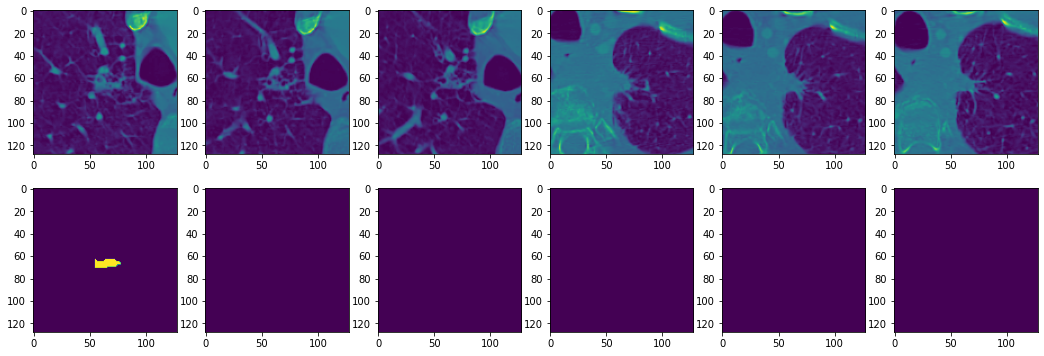

In [13]:
plt.rcParams['figure.figsize'] = [18, 6]

for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.imshow(X_test[i])

    plt.subplot(2, 6, i+7)
    plt.imshow(Y_test[i])
plt.show();

## Val data

In [14]:
#Save filenames
for root, dirs, files in os.walk('./LIDC_crops/LIDC_DLCV_version'):
    if root.endswith('/val/images'):
        filnavne_billeder=files
    if root.endswith('/val/lesions'):
        filnavne_lesions=files

#Sort names
filnavne_billeder_sort=sorted(filnavne_billeder)
filnavne_lesions_sort=sorted(filnavne_lesions)

billeder_root='./LIDC_crops/LIDC_DLCV_version/val/images'
lesions_root='./LIDC_crops/LIDC_DLCV_version/val/lesions'

images_val=[]
lesions_val=[]

#Save images
for i in range(len(filnavne_billeder_sort)):
          images_val.append(imread(os.path.join(billeder_root, filnavne_billeder_sort[i])))

#Saving the annotations
r=random.randint(0,4)
for i in range(len(filnavne_lesions_sort)):
          if name_choose=="random":
            if annotation_names[r] in filnavne_lesions_sort[i]:
              lesions_val.append(imread(os.path.join(lesions_root, filnavne_lesions_sort[i])))
              r=random.randint(0,4)

          elif annotation_names[name_choose] in filnavne_lesions_sort[i]:
            lesions_val.append(imread(os.path.join(lesions_root, filnavne_lesions_sort[i])))

Resizing images.

In [15]:
size = (128, 128)
X_val = [resize(x, size, mode='constant', anti_aliasing=True) for x in images_val]
Y_val = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in lesions_val]

X_val = np.array(X_val, np.float32)
Y_val = np.array(Y_val, np.float32)
print('Loaded %d images' % len(X_val))

Loaded 1993 images


Draw some of the images to ensure they are correct...

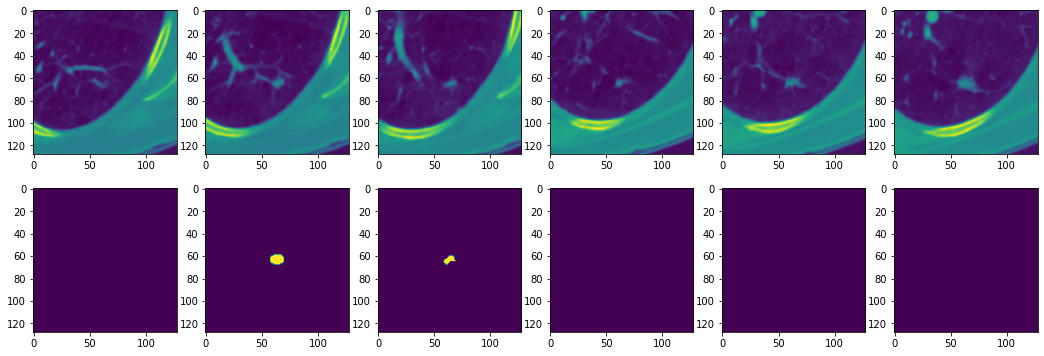

In [16]:
plt.rcParams['figure.figsize'] = [18, 6]

for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.imshow(X_val[i])

    plt.subplot(2, 6, i+7)
    plt.imshow(Y_val[i])
plt.show();

## Checking dimension

In [17]:
X_train.shape
X_test.shape
X_val.shape

(1993, 128, 128)

In [18]:
Y_train.shape
Y_test.shape
Y_val.shape

(1993, 128, 128)

## PyTorch DataLoader

Let's use PyTorch data loader to iterate images in batches. Notice that images are loaded in the format $N\times H\times W\times C$, but PyTorch prefers $N\times C\times H\times W$. We change the array order.

In [19]:
ix_train = np.random.choice(len(X_train),len(X_train),False)#4000
ix_test = np.random.choice(len(X_test),len(X_test),False)#100
ix_val = np.random.choice(len(X_val),len(X_val),False)#500

In [20]:
len(X_train)
len(X_test)
len(X_val)

1993

In [21]:
batch_size = 6
data_tr = DataLoader(list(zip(X_train[ix_train], Y_train[ix_train])), batch_size=batch_size, shuffle=True)
data_val = DataLoader(list(zip(X_val[ix_val], Y_val[ix_val])), batch_size=batch_size, shuffle=True)
data_ts = DataLoader(list(zip(X_test[ix_test], Y_test[ix_test])), batch_size=batch_size, shuffle=True)

## Device

Check if GPU is available.

In [22]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


## Loss functions

Here's an overview of different custommade loss functions. The BCE_loss_positive is used in this notebook. 

In [23]:
'''
def bce_loss(y_real, y_pred):
    m=nn.Sigmoid()
    return nn.BCELoss()(m(y_pred),y_real)
    #return torch.mean(y_pred - y_real*y_pred + torch.log(1 + torch.exp(-y_pred)))
    '''

'\ndef bce_loss(y_real, y_pred):\n    m=nn.Sigmoid()\n    return nn.BCELoss()(m(y_pred),y_real)\n    #return torch.mean(y_pred - y_real*y_pred + torch.log(1 + torch.exp(-y_pred)))\n    '

In [24]:
def bce_loss_positive(y_real, y_pred):
    pos_weight = torch.ones([1]).to(device)
    m=nn.BCEWithLogitsLoss(pos_weight=pos_weight)

    return m(y_pred,y_real)

In [25]:
'''
def dice_loss(y_real, y_pred):
    #return 1-(1/(256*256))*torch.sum((2*y_real*y_pred)/(y_real+y_pred))

    #husk tag sigmoid af y pred da modellen ikke gør det! 
    return 1-torch.mean(2*y_real*F.sigmoid(y_pred))/torch.mean(y_real+F.sigmoid(y_pred))
    '''

'\ndef dice_loss(y_real, y_pred):\n    #return 1-(1/(256*256))*torch.sum((2*y_real*y_pred)/(y_real+y_pred))\n\n    #husk tag sigmoid af y pred da modellen ikke gør det! \n    return 1-torch.mean(2*y_real*F.sigmoid(y_pred))/torch.mean(y_real+F.sigmoid(y_pred))\n    '

In [26]:
'''
def focal_loss(y_real, y_pred):
    return -torch.sum(((1-F.sigmoid(y_pred))**2)*y_real*torch.log(F.sigmoid(y_pred))  + (1-y_real)*torch.log(1-F.sigmoid(y_pred))          )
    '''

'\ndef focal_loss(y_real, y_pred):\n    return -torch.sum(((1-F.sigmoid(y_pred))**2)*y_real*torch.log(F.sigmoid(y_pred))  + (1-y_real)*torch.log(1-F.sigmoid(y_pred))          )\n    '

## Performance

A custommade function to evaluate the models. Performance measures: Accuracy, sensitivity, specificity, intersection over union (IoU) and dice overlap.

In [27]:
#Custom made
def calculate_performance_no_T(model,data,n):
  '''
  Model: The PyTorch model
  data: The data which should be used for validating (use data_val)
  thres: The threshold of when to let pixels be 0 or 1
  n: number of iterations the model should be runned 
  '''
  for thres in [0.1,0.3,0.5,0.7,0.9]:
    print('##############################')
    print("Threshold is: {}".format(thres))


    Predict_list=[]
    Target_list=[]
    
    model.eval()

    for i in range(n):
      X_val, Y_val = next(iter(data))
      if i==0:
        #Output fra modellen
        output = F.sigmoid(model(X_val.to(device).unsqueeze(1))).detach().cpu()
        target=Y_val.unsqueeze(1)
      else:
        o= F.sigmoid(model(X_val.to(device).unsqueeze(1))).detach().cpu()
        t=Y_val.unsqueeze(1)

        output=torch.cat((output,o),0)
        target=torch.cat((target,t),0)

    #Anvender threshold
    output[output<thres]=0 
    output[output>=thres]=1
    target[target<thres]=0 
    target[target>=thres]=1

    #Out og target ind i list
    Predict_list.append(output.view(-1))
    Target_list.append(target.view(-1))

    #Liste til array
    flat_list_Predict = [item.item() for sublist in Predict_list for item in sublist] #Save all tensors as one list
    flat_list_Target = [item.item() for sublist in Target_list for item in sublist]   #Save all tensors as one list



    print("-------Confusion matrix--------")
    from sklearn.metrics import confusion_matrix
    print(confusion_matrix(flat_list_Target,flat_list_Predict))
    print("-------------------------------")
    tn, fp, fn, tp = confusion_matrix(flat_list_Target,flat_list_Predict).ravel()

    ###Accuracy
    from sklearn.metrics import accuracy_score
    print("Accuracy score: {}".format(accuracy_score(flat_list_Target,flat_list_Predict)))


    ##Sensititvity (recall of the positive class)
    Sensitivity = tp / (tp+fn)
    print("Sensitivity {}".format(Sensitivity))

    ##Specificity (recall of the negative class)
    specificity = tn / (tn+fp)
    print("Specificity {}".format(specificity))

    ####IoU######
    #nominator=(flat_list_Predict[flat_list_Predict==flat_list_Target])
    sPredict=np.array(flat_list_Predict)
    sTarget=np.array(flat_list_Target)
    nominator=sPredict[(sPredict==1)&(sTarget==1)].sum()
    denominator=sPredict.sum() + sTarget.sum()
    IoU=nominator/denominator
    print("IoU is {}".format(IoU))

    ##Dice overlap""
    #https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient
    DSC=2*tp/(2*tp+fp+fn)
    print("Dice overlap is: {}".format(DSC))
    print('##############################')



-----------------------------------------------------------------------------------------

# SegNet

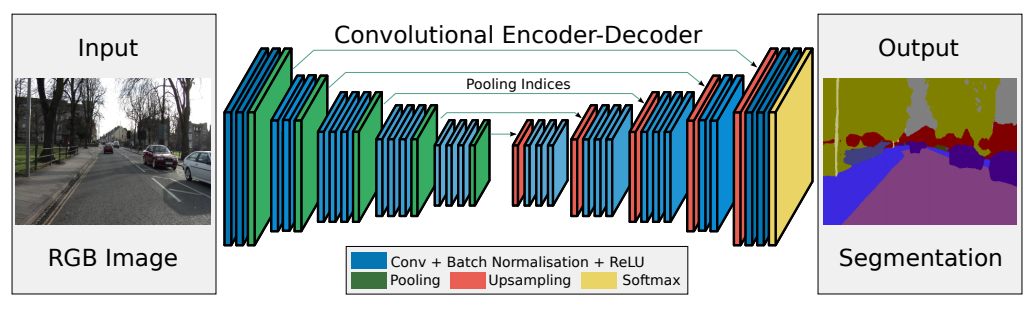

* Badrinarayanan, V., Kendall, A., & Cipolla, R. (2015). [SegNet: A deep convolutional
encoder-decoder architecture for image segmentation](https://arxiv.org/pdf/1511.00561.pdf)

In [28]:

class SegNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        self.enc_conv0 = nn.Conv2d(1, 128, 3, padding=1)
        self.pool0 = nn.MaxPool2d(2)  # 128 -> 64
        self.enc_conv1 = nn.Conv2d(128, 128, 3, padding=1)
        self.pool1 = nn.MaxPool2d(2)  # 64 -> 32
        self.enc_conv2 = nn.Conv2d(128, 128, 3, padding=1)
        self.pool2 = nn.MaxPool2d(2)  # 32 -> 16
        self.enc_conv3 = nn.Conv2d(128, 128, 3, padding=1)
        self.pool3 = nn.MaxPool2d(2)  # 16 -> 8
        self.enc_conv4 = nn.Conv2d(128, 128, 3, padding=1)
        self.pool4 = nn.MaxPool2d(2)  # 8 -> 4

        # bottleneck
        self.bottleneck_conv = nn.Conv2d(128, 128, 3, padding=1)

        # decoder (upsampling)
        self.upsample0 = nn.Upsample(scale_factor=2)  # 4 -> 8
        self.dec_conv0 = nn.Conv2d(128, 128, 3, padding=1)
        self.upsample1 = nn.Upsample(scale_factor=2)  # 8 -> 16
        self.dec_conv1 = nn.Conv2d(128, 128, 3, padding=1)
        self.upsample2 = nn.Upsample(scale_factor=2)  # 16 -> 32
        self.dec_conv2 = nn.Conv2d(128, 128, 3, padding=1)
        self.upsample3 = nn.Upsample(scale_factor=2)  # 32 -> 64
        self.dec_conv3 = nn.Conv2d(128, 128, 3, padding=1)
        self.upsample4 = nn.Upsample(scale_factor=2)  # 64 -> 128
        self.dec_conv4 = nn.Conv2d(128, 1, 3, padding=1)

    def forward(self, x):
        # encoder
        
        self.enc_conv0(x)
        e0 = self.pool0(F.relu(self.enc_conv0(x)))
        e1 = self.pool1(F.relu(self.enc_conv1(e0)))
        e2 = self.pool2(F.relu(self.enc_conv2(e1)))
        e3 = self.pool3(F.relu(self.enc_conv3(e2)))
        e4 = self.pool4(F.relu(self.enc_conv4(e3)))

        # bottleneck
        b = F.relu(self.bottleneck_conv(e4))

        # decoder
        d0 = F.relu(self.dec_conv0(self.upsample0(b)))
        d1 = F.relu(self.dec_conv1(self.upsample1(d0)))
        d2 = F.relu(self.dec_conv2(self.upsample1(d1)))
        d3 = F.relu(self.dec_conv3(self.upsample1(d2)))
        d4 = self.dec_conv4(self.upsample4(d3))  # no activation
        return d4
       

'\nclass SegNet(nn.Module):\n    def __init__(self):\n        super().__init__()\n\n        # encoder (downsampling)\n        self.enc_conv0 = nn.Conv2d(1, 128, 3, padding=1)\n        self.pool0 = nn.MaxPool2d(2)  # 128 -> 64\n        self.enc_conv1 = nn.Conv2d(128, 128, 3, padding=1)\n        self.pool1 = nn.MaxPool2d(2)  # 64 -> 32\n        self.enc_conv2 = nn.Conv2d(128, 128, 3, padding=1)\n        self.pool2 = nn.MaxPool2d(2)  # 32 -> 16\n        self.enc_conv3 = nn.Conv2d(128, 128, 3, padding=1)\n        self.pool3 = nn.MaxPool2d(2)  # 16 -> 8\n        self.enc_conv4 = nn.Conv2d(128, 128, 3, padding=1)\n        self.pool4 = nn.MaxPool2d(2)  # 8 -> 4\n\n        # bottleneck\n        self.bottleneck_conv = nn.Conv2d(128, 128, 3, padding=1)\n\n        # decoder (upsampling)\n        self.upsample0 = nn.Upsample(scale_factor=2)  # 4 -> 8\n        self.dec_conv0 = nn.Conv2d(128, 128, 3, padding=1)\n        self.upsample1 = nn.Upsample(scale_factor=2)  # 8 -> 16\n        self.dec_conv1 

# U-Net

In [29]:
class UNet2(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        self.enc_conv0 = nn.Conv2d(1, 64, 3, padding=1)
        self.pool0 = nn.MaxPool2d(2)  # 256 -> 128
        self.enc_conv1 = nn.Conv2d(64, 128, 3, padding=1)
        self.pool1 = nn.MaxPool2d(2)  # 128 -> 64
        self.enc_conv2 = nn.Conv2d(128, 256, 3, padding=1)
        self.pool2 = nn.MaxPool2d(2)  # 64 -> 32
        self.enc_conv3 = nn.Conv2d(256, 512, 3, padding=1)
        self.pool3 = nn.MaxPool2d(2)  # 32 -> 16
        self.enc_conv4 = nn.Conv2d(512, 1024, 3, padding=1)
        self.pool4 = nn.MaxPool2d(2)  # 32 -> 16

        # bottleneck
        self.bottleneck_conv1 = nn.Conv2d(1024, 2048, 3, padding=1)
        self.bottleneck_conv2 = nn.Conv2d(2048, 1024, 3, padding=1)

        # decoder (upsampling)
        self.upsample0 = nn.Upsample(scale_factor=2)  # 16 -> 32
        self.dec_conv0 = nn.Conv2d(2048, 512, 3, padding=1)
        self.upsample1 = nn.Upsample(scale_factor=2)  # 32 -> 64
        self.dec_conv1 = nn.Conv2d(1024, 256, 3, padding=1)
        self.upsample2 = nn.Upsample(scale_factor=2)  # 64 -> 128
        self.dec_conv2 = nn.Conv2d(512, 128, 3, padding=1)
        self.upsample3 = nn.Upsample(scale_factor=2)  # 128 -> 256
        self.dec_conv3 = nn.Conv2d(256, 64, 3, padding=1)
        self.upsample4 = nn.Upsample(scale_factor=2)  # 128 -> 256
        self.dec_conv4 = nn.Conv2d(128, 1, 3, padding=1)

    def forward(self, x):
        # encoder
        e0s = F.relu(self.enc_conv0(x))
        e0 = self.pool0(e0s)
        e1s = F.relu(self.enc_conv1(e0))
        e1 = self.pool1(e1s)
        e2s = F.relu(self.enc_conv2(e1))
        e2 = self.pool2(e2s)
        e3s = F.relu(self.enc_conv3(e2))
        e3 = self.pool3(e3s)
        e4s = F.relu(self.enc_conv4(e3))
        e4 = self.pool4(e4s)
        
        # bottleneck
        b = F.relu(self.bottleneck_conv1(e4))
        b = F.relu(self.bottleneck_conv2(b))

        # decoder
        d0 = F.relu(self.dec_conv0(torch.cat([self.upsample0(b), e4s],dim=1)))
        d1 = F.relu(self.dec_conv1(torch.cat([self.upsample1(d0), e3s], dim=1)))
        d2 = F.relu(self.dec_conv2(torch.cat([self.upsample2(d1), e2s], dim=1)))
        d3 = F.relu(self.dec_conv3(torch.cat([self.upsample3(d2), e1s], dim=1)))
        d4 = self.dec_conv4(torch.cat([self.upsample4(d3), e0s], dim=1))  # no activation
        return d4

In [30]:
'''
class UNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        self.enc_conv0 = nn.Conv2d(1, 64, 3, padding=1)
        self.pool0 = nn.MaxPool2d(2)  # 256 -> 128
        self.enc_conv1 = nn.Conv2d(64, 128, 3, padding=1)
        self.pool1 = nn.MaxPool2d(2)  # 128 -> 64
        self.enc_conv2 = nn.Conv2d(128, 256, 3, padding=1)
        self.pool2 = nn.MaxPool2d(2)  # 64 -> 32
        self.enc_conv3 = nn.Conv2d(256, 512, 3, padding=1)
        self.pool3 = nn.MaxPool2d(2)  # 32 -> 16

        # bottleneck
        self.bottleneck_conv1 = nn.Conv2d(512, 1024, 3, padding=1)
        self.bottleneck_conv2 = nn.Conv2d(1024, 512, 3, padding=1)

        # decoder (upsampling)
        self.upsample0 = nn.Upsample(scale_factor=2)  # 16 -> 32
        self.dec_conv0 = nn.Conv2d(1024, 256, 3, padding=1)
        self.upsample1 = nn.Upsample(scale_factor=2)  # 32 -> 64
        self.dec_conv1 = nn.Conv2d(512, 128, 3, padding=1)
        self.upsample2 = nn.Upsample(scale_factor=2)  # 64 -> 128
        self.dec_conv2 = nn.Conv2d(256, 64, 3, padding=1)
        self.upsample3 = nn.Upsample(scale_factor=2)  # 128 -> 256
        self.dec_conv3 = nn.Conv2d(128, 1, 3, padding=1)

    def forward(self, x):
        # encoder
        e0s = F.relu(self.enc_conv0(x))
        e0 = self.pool0(e0s)
        e1s = F.relu(self.enc_conv1(e0))
        e1 = self.pool1(e1s)
        e2s = F.relu(self.enc_conv2(e1))
        e2 = self.pool2(e2s)
        e3s = F.relu(self.enc_conv3(e2))
        e3 = self.pool3(e3s)
        
        # bottleneck
        b = F.relu(self.bottleneck_conv1(e3))
        b = F.relu(self.bottleneck_conv2(b))

        # decoder
        d0 = F.relu(self.dec_conv0(torch.cat([self.upsample0(b), e3s],dim=1)))
        d1 = F.relu(self.dec_conv1(torch.cat([self.upsample1(d0), e2s], dim=1)))
        d2 = F.relu(self.dec_conv2(torch.cat([self.upsample2(d1), e1s], dim=1)))
        d3 = self.dec_conv3(torch.cat([self.upsample3(d2), e0s], dim=1))  # no activation
        return d3
        '''

'\nclass UNet(nn.Module):\n    def __init__(self):\n        super().__init__()\n\n        # encoder (downsampling)\n        self.enc_conv0 = nn.Conv2d(1, 64, 3, padding=1)\n        self.pool0 = nn.MaxPool2d(2)  # 256 -> 128\n        self.enc_conv1 = nn.Conv2d(64, 128, 3, padding=1)\n        self.pool1 = nn.MaxPool2d(2)  # 128 -> 64\n        self.enc_conv2 = nn.Conv2d(128, 256, 3, padding=1)\n        self.pool2 = nn.MaxPool2d(2)  # 64 -> 32\n        self.enc_conv3 = nn.Conv2d(256, 512, 3, padding=1)\n        self.pool3 = nn.MaxPool2d(2)  # 32 -> 16\n\n        # bottleneck\n        self.bottleneck_conv1 = nn.Conv2d(512, 1024, 3, padding=1)\n        self.bottleneck_conv2 = nn.Conv2d(1024, 512, 3, padding=1)\n\n        # decoder (upsampling)\n        self.upsample0 = nn.Upsample(scale_factor=2)  # 16 -> 32\n        self.dec_conv0 = nn.Conv2d(1024, 256, 3, padding=1)\n        self.upsample1 = nn.Upsample(scale_factor=2)  # 32 -> 64\n        self.dec_conv1 = nn.Conv2d(512, 128, 3, padding=1)

# Train

In [31]:
def train(model, opt, loss_fn, epochs, data_tr, data_val):
    X_val, Y_val = next(iter(data_val))

    epochnumber = []
    all_train_losses = []
    all_test_losses = []

    for epoch in range(epochs):
        tic = time()
        print('* Epoch %d/%d' % (epoch+1, epochs))

        epochnumber.append(epoch)

        avg_loss = 0
        model.train()  # train mode
        for X_batch, Y_batch in data_tr:
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)

            # set parameter gradients to zero
            opt.zero_grad()

            # forward
            Y_pred = model(X_batch.unsqueeze(1)) #oprdindeligt havde vi 3 lag (RGB), nu har vi kun 1 (greyscale) -> 
            loss = loss_fn(Y_batch.unsqueeze(1), Y_pred)  # forward-pass
            loss.backward()  # backward-pass
            opt.step()  # update weights

            # calculate metrics to show the user
            avg_loss += loss / len(data_tr)
        toc = time()
        print(' - loss: %f' % avg_loss)

        all_train_losses.append(avg_loss)


        #####test los####
        #avg_loss_test = 0
        Y_pred = model(X_val.unsqueeze(1).to(device)) #oprdindeligt havde vi 3 lag (RGB), nu har vi kun 1 (greyscale) -> 
        loss = loss_fn(Y_val.unsqueeze(1).to(device), Y_pred)  # forward-pass
        all_test_losses.append(loss)



        ################################
        #avg_loss_test = 0
        #model.eval()  # train mode
        #for X_batch, Y_batch in data_val:
        #    X_batch = X_batch.to(device)
        #    Y_batch = Y_batch.to(device)#

            

            # forward
       #     Y_pred = model(X_batch.unsqueeze(1)) #oprdindeligt havde vi 3 lag (RGB), nu har vi kun 1 (greyscale) -> 
       #     loss = loss_fn(Y_batch.unsqueeze(1), Y_pred)  # forward-pass
            #loss.backward()  # backward-pass
            #opt.step()  # update weights

            # calculate metrics to show the user
           # avg_loss_test += loss / len(data_tr)
        

        #all_test_losses.append(avg_loss_test)
        #del X_batch
        #del Y_batch

        ###############################




        # show intermediate results
        model.eval()  # testing mode
        Y_hat = F.sigmoid(model(X_val.to(device).unsqueeze(1))).detach().cpu()
        print(Y_hat.shape)
        clear_output(wait=True)

        plt.figure(1)
        for k in range(6):
            plt.subplot(2, 6, k+1)
            plt.imshow(X_val[k].numpy())
            plt.title('Real')
            plt.axis('off')

            plt.subplot(2, 6, k+7)
            plt.imshow(Y_hat[k,0])
            
            plt.title('Output')
            plt.axis('off')

        plt.suptitle('%d / %d - loss: %f' % (epoch+1, epochs, avg_loss))
        #plt.show()

        plt.figure(2)
        plt.xlabel('Epochs'), plt.ylabel('Loss')
        plt.plot(epochnumber, all_train_losses, 'r', epochnumber, all_test_losses, 'g')
        plt.legend(['Train Loss', 'Validation Loss'])
        plt.show()

        for k in range(6):
            plt.subplot(2, 6, k+1)
            plt.imshow(Y_val[k])
            plt.title('True')
            plt.axis('off')

        plt.show()
        

In [32]:
'''
def predict(model, data):
    model.eval()  # testing mode
    Y_pred = [F.sigmoid(model(X_batch.to(device))) for X_batch, _ in data]
    return np.array(Y_pred)
    '''

'\ndef predict(model, data):\n    model.eval()  # testing mode\n    Y_pred = [F.sigmoid(model(X_batch.to(device))) for X_batch, _ in data]\n    return np.array(Y_pred)\n    '

# Run models

## SegNet

In [ ]:
model1 = SegNet().to(device)
summary(model1, (1, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1        [-1, 128, 128, 128]           1,280
            Conv2d-2        [-1, 128, 128, 128]           1,280
         MaxPool2d-3          [-1, 128, 64, 64]               0
            Conv2d-4          [-1, 128, 64, 64]         147,584
         MaxPool2d-5          [-1, 128, 32, 32]               0
            Conv2d-6          [-1, 128, 32, 32]         147,584
         MaxPool2d-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,584
         MaxPool2d-9            [-1, 128, 8, 8]               0
           Conv2d-10            [-1, 128, 8, 8]         147,584
        MaxPool2d-11            [-1, 128, 4, 4]               0
           Conv2d-12            [-1, 128, 4, 4]         147,584
         Upsample-13            [-1, 128, 8, 8]               0
           Conv2d-14            [-1, 12

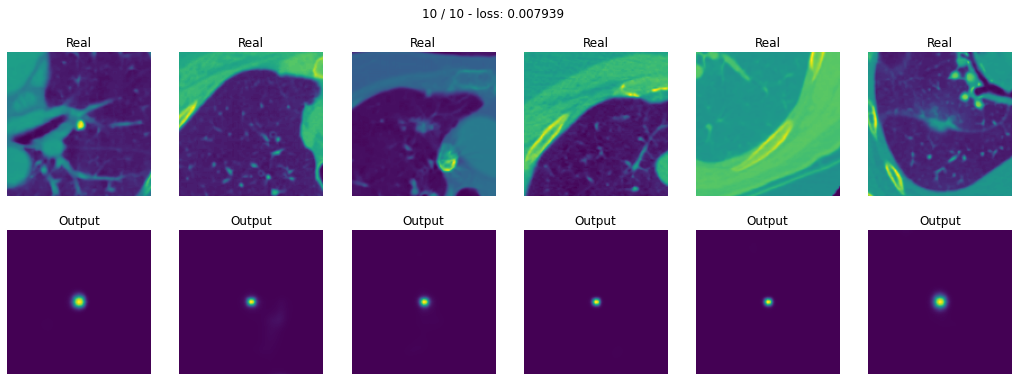

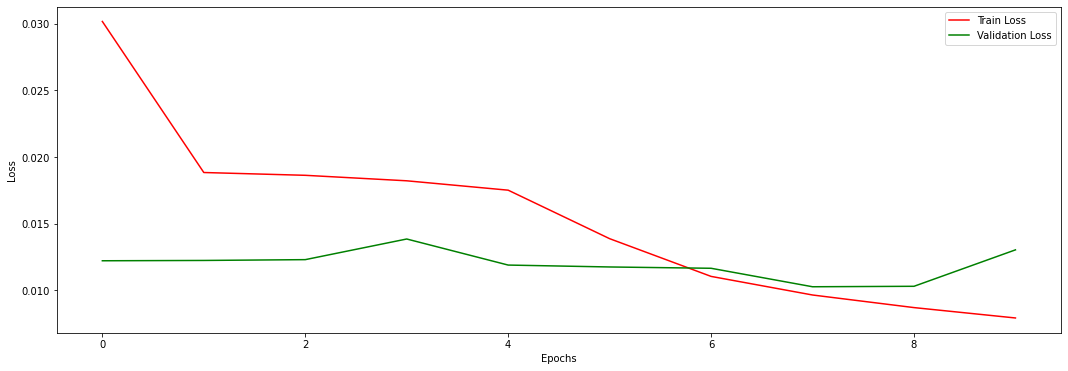

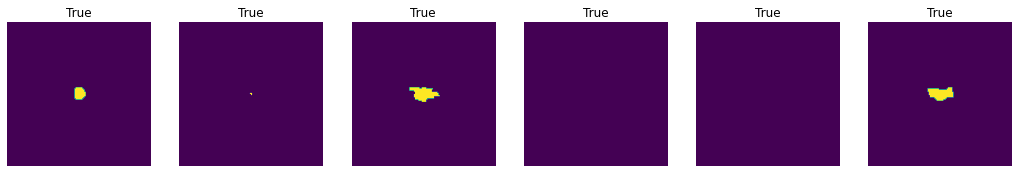

In [ ]:
train(model1, optim.Adam(model1.parameters(),lr=0.0001), bce_loss_positive, 10, data_tr, data_val) #loss=0.007090

In [ ]:
#torch.save(model1.state_dict(), 'gdrive/My Drive/DLiCV_project/Project2/SegNet_ensemble_1')
#torch.save(model1.state_dict(), 'gdrive/My Drive/DLiCV_project/Project2/SegNet_ensemble_2')
#torch.save(model1.state_dict(), 'gdrive/My Drive/DLiCV_project/Project2/SegNet_ensemble_3')
#torch.save(model1.state_dict(), 'gdrive/My Drive/DLiCV_project/Project2/SegNet_ensemble_4')

In [ ]:
#calculate_performance_no_T(model,data_tr,5)
#calculate_performance_no_T(model,data_val,5)
#calculate_performance_no_T(model,data_ts,5)

In [ ]:
#calculate_performance_no_T(model,data_ts,50)

In [ ]:
# Save model state
#tid_andel=datetime.datetime.today()#
#timestampSTR_andel=tid_andel.strftime("%d-%b-%H:%M")
#dato = timestampSTR_andel
#torch.save(model.state_dict(), 'gdrive/My Drive/DLiCV_project/Project2/SegNet_30epoker_loss0035'+dato)

In [ ]:
#calculate_performance_no_T(model,data_tr,5)
#calculate_performance_no_T(model,data_val,5)
#calculate_performance_no_T(model,data_ts,5)

In [ ]:
#model = SegNet().to(device)
#optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

#model.load_state_dict(torch.load('gdrive/My Drive/DLiCV_project/Project2/SegNet_90epoker_loss002416-Jun-12:19'))
#optimizer.load_state_dict(torch.load('gdrive/My Drive/DLiCV_project/Project2/SegNet_90epoker_loss002416-Jun-12:19'))

## U-Net

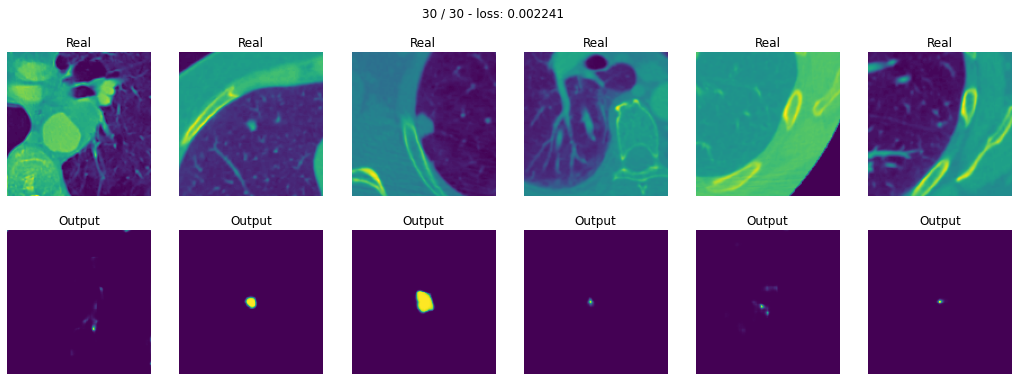

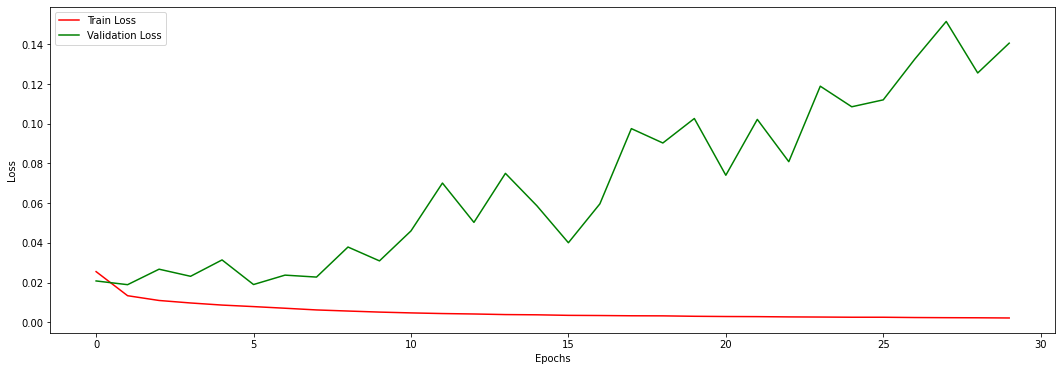

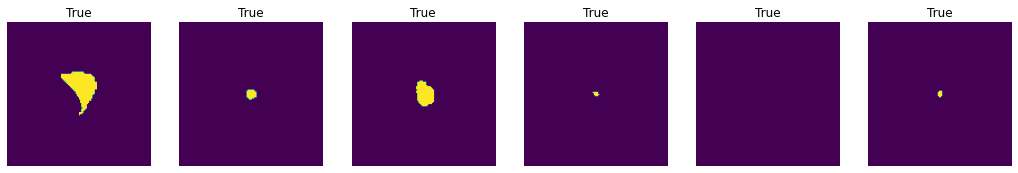

In [ ]:
model = UNet().to(device)
optimizer = optim.Adam(model.parameters(),lr=0.0001)

loss_thres = train(model, optimizer, bce_loss_positive, 30, data_tr, data_val)

In [ ]:
# Save model state
tid_andel=datetime.datetime.today()#
timestampSTR_andel=tid_andel.strftime("%d-%b-%H:%M")
dato = timestampSTR_andel
torch.save(model.state_dict(), 'gdrive/My Drive/DLiCV_project/Project2/UNet_vanilla_30epoker_loss0037'+dato)

In [ ]:
calculate_performance_no_T(model,data_tr,5)
calculate_performance_no_T(model,data_val,5)
calculate_performance_no_T(model,data_ts,5)

##############################
Threshold is: 0.1


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


-------Confusion matrix--------
[[488141   1213]
 [    40   2126]]
-------------------------------
Accuracy score: 0.9974507649739583
Sensitivity 0.9815327793167128
Specificity 0.9975212218557526
IoU is 0.38619436875567664
Dice overlap is: 0.7723887375113533
##############################
##############################
Threshold is: 0.3
-------Confusion matrix--------
[[489555    294]
 [   143   1528]]
-------------------------------
Accuracy score: 0.9991109212239583
Sensitivity 0.9144225014961102
Specificity 0.9993998150450445
IoU is 0.4374463212138563
Dice overlap is: 0.8748926424277126
##############################
##############################
Threshold is: 0.5
-------Confusion matrix--------
[[486928    653]
 [   407   3532]]
-------------------------------
Accuracy score: 0.9978434244791666
Sensitivity 0.8966742828128966
Specificity 0.9986607353444864
IoU is 0.4347612013786312
Dice overlap is: 0.8695224027572624
##############################
##############################
Thr

In [ ]:
calculate_performance_no_T(model2,data_tr,5)
calculate_performance_no_T(model2,data_val,5)
calculate_performance_no_T(model2,data_ts,5)

##############################
Threshold is: 0.1


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


-------Confusion matrix--------
[[489066    762]
 [    24   1668]]
-------------------------------
Accuracy score: 0.99840087890625
Sensitivity 0.9858156028368794
Specificity 0.9984443518949508
IoU is 0.40465793304221254
Dice overlap is: 0.8093158660844251
##############################
##############################
Threshold is: 0.3
-------Confusion matrix--------
[[489524    374]
 [    79   1543]]
-------------------------------
Accuracy score: 0.999078369140625
Sensitivity 0.9512946979038225
Specificity 0.9992365757769984
IoU is 0.4359988697372139
Dice overlap is: 0.8719977394744278
##############################
##############################
Threshold is: 0.5
-------Confusion matrix--------
[[489353    160]
 [   279   1728]]
-------------------------------
Accuracy score: 0.9991068522135417
Sensitivity 0.8609865470852018
Specificity 0.9996731445334445
IoU is 0.44364569961489086
Dice overlap is: 0.8872913992297817
##############################
##############################
Thres

##Draw model

In [ ]:
make_dot(model(torch.randn(20, 1, 128, 128).cuda()), params=dict(model.named_parameters()))

# Training models to the ensemble model 

In [ ]:
model = UNet2().to(device)
optimizer = optim.Adam(model.parameters(),lr=0.0001)

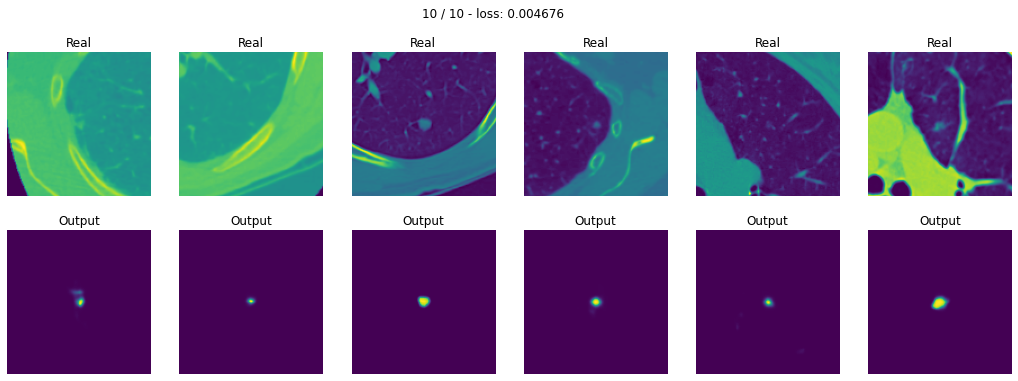

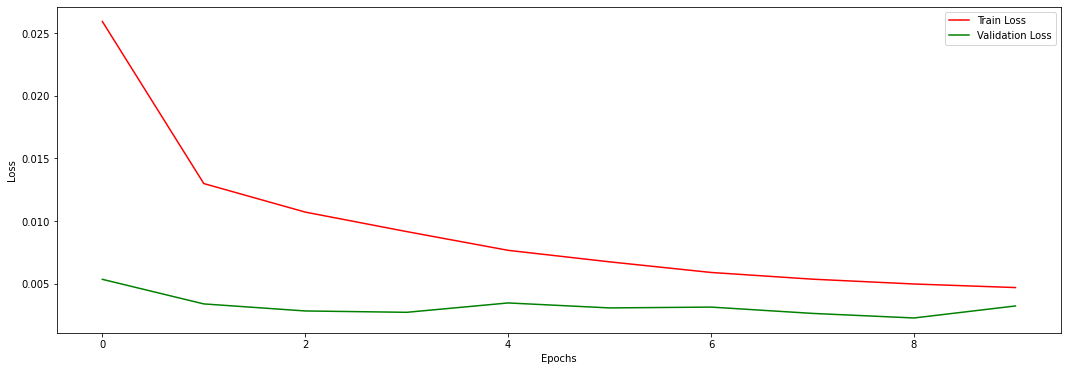

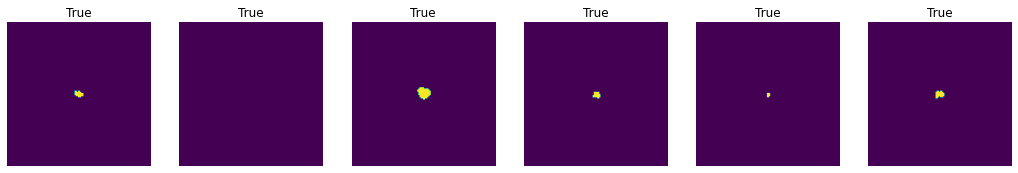

In [ ]:
train(model, optimizer, bce_loss_positive, 10, data_tr, data_val)

In [ ]:
#To save models
#torch.save(model.state_dict(), 'gdrive/My Drive/DLiCV_project/Project2/SegNet_ensemble_1_10epochs')
#torch.save(model.state_dict(), 'gdrive/My Drive/DLiCV_project/Project2/SegNet_ensemble_2_10epochs')
#torch.save(model.state_dict(), 'gdrive/My Drive/DLiCV_project/Project2/SegNet_ensemble_3_10epochs')
#torch.save(model.state_dict(), 'gdrive/My Drive/DLiCV_project/Project2/SegNet_ensemble_4_10epochs')

# Ensemble model

## Create model

In [33]:
#https://discuss.pytorch.org/t/custom-ensemble-approach/52024/4
class MyEnsemble(nn.Module):
    def __init__(self, modelA, modelB,modelC,modelD):
        super(MyEnsemble, self).__init__()
        self.modelA = modelA
        self.modelB = modelB
        self.modelC = modelC
        self.modelD = modelD
        self.n_models=4
        # Remove last linear layer
        #self.modelA.fc = nn.Identity()
        #self.modelB.fc = nn.Identity()
        
        # Create new classifier
        self.classifier = nn.Linear(128*128*self.n_models, 128*128).to(device)
        
    def forward(self, x):
        x1 = self.modelA(x.clone().to(device))  # clone to make sure x is not changed by inplace methods
        x1 = x1.view(x1.size(0), -1).to(device)
        x2 = self.modelB(x.to(device))
        x2 = x2.view(x2.size(0), -1).to(device)
        x3 = self.modelC(x.to(device))
        x3 = x3.view(x3.size(0), -1).to(device)
        x4 = self.modelD(x.to(device))
        x4 = x4.view(x4.size(0), -1).to(device)


        #x = torch.cat((x1, x2,x3,x4), dim=1).to(device) 
        #x = self.classifier(x).to(device) 

        x=1/4*x1+1/4*x2+1/4*x3+1/4*x4
        
        return x.to(device).view(6 ,1, 128, 128),x1.view(6 ,1, 128, 128),x2.view(6 ,1, 128, 128),x3.view(6 ,1, 128, 128),x4.view(6 ,1, 128, 128) #skal viewes tilbage igen!

In [34]:
modelA = UNet2().to(device)
modelA.load_state_dict(torch.load('gdrive/My Drive/DLiCV_project/Project2/SegNet_ensemble_1_10epochs'))
modelA.eval()


modelB = UNet2().to(device)
modelB.load_state_dict(torch.load('gdrive/My Drive/DLiCV_project/Project2/SegNet_ensemble_2_10epochs'))
modelB.eval()

modelC = UNet2().to(device)
modelC.load_state_dict(torch.load('gdrive/My Drive/DLiCV_project/Project2/SegNet_ensemble_3_10epochs'))
modelC.eval()

modelD = UNet2().to(device)
modelD.load_state_dict(torch.load('gdrive/My Drive/DLiCV_project/Project2/SegNet_ensemble_4_10epochs'))
modelD.eval()


UNet2(
  (enc_conv0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (enc_conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (enc_conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (enc_conv3): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (enc_conv4): Conv2d(512, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bottleneck_conv1): Conv2d(1024, 2048, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bottleneck_conv2): Conv2d(2048, 1024, kernel_size=(3, 3)

In [35]:
# Freeze these models
for param in modelA.parameters():
    param.requires_grad_(False)

for param in modelB.parameters():
    param.requires_grad_(False)


for param in modelC.parameters():
    param.requires_grad_(False)

for param in modelD.parameters():
    param.requires_grad_(False)

In [37]:
model = MyEnsemble(modelA, modelB,modelC,modelD)
model.eval()

MyEnsemble(
  (modelA): UNet2(
    (enc_conv0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (pool0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (enc_conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (enc_conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (enc_conv3): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (enc_conv4): Conv2d(512, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (bottleneck_conv1): Conv2d(1024, 2048, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bottlene

In [40]:
X_val, Y_val = next(iter(data_val))

Y_hat,Y_hat_m1,Y_hat_m2,Y_hat_m3,Y_hat_m4 = model(X_val.to(device).unsqueeze(1))
Y_hat=F.sigmoid(Y_hat).detach().cpu()
Y_hat_m1=F.sigmoid(Y_hat_m1).detach().cpu()
Y_hat_m2=F.sigmoid(Y_hat_m2).detach().cpu()
Y_hat_m3=F.sigmoid(Y_hat_m3).detach().cpu()
Y_hat_m4=F.sigmoid(Y_hat_m4).detach().cpu()


#Y_hat=Y_hat).detach().cpu()


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


## Define colors for plotting

In [53]:
import matplotlib

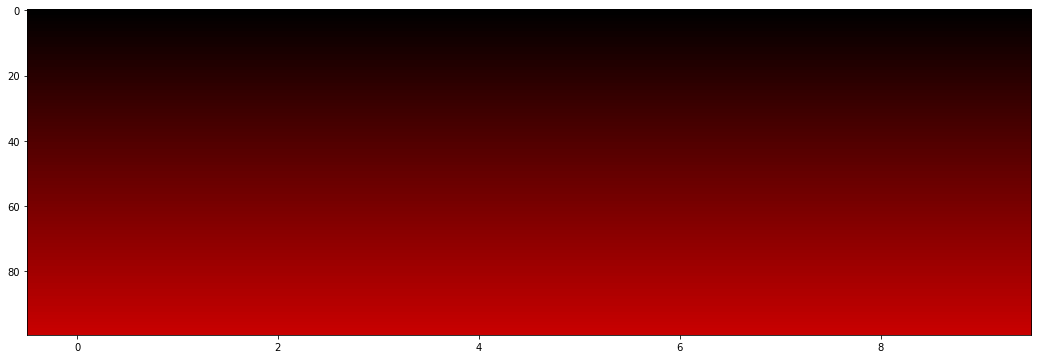

In [104]:
'''
Forklaring:
Den øverste linje af hver tuple, diffinerer hvor meget farve der skal være øverst på billedet

Den nederste linje af hver tuple, diffinerer hvor meget farve der skal være nederst på billedet
'''
plt.figure()
a=np.outer(np.arange(0,1,0.01),np.ones(10))
fact = 1.0/255.0
cdict2 = {'red':  [(0.0,   0*fact,  0*fact), #helt SORT!!!!!
                   (0.25, 50*fact, 50*fact), #mere rød
                   (0.5,  100*fact, 100*fact), #mere rød
                   (0.75, 150*fact, 150*fact), #mere mere mere rød
                   (1.0,   200*fact,  200*fact)], #helt rød
         'green': [(0.0,   0*fact,  0*fact), #ingen grøn -> helt sort
                   (0.25, 0*fact, 0*fact),#ingen grøn
                   (0.5,  0*fact, 0*fact),#ingen grøn
                   (0.75, 0*fact, 0*fact),#ingen grøn
                   (1.0,   0*fact,  0*fact)],
         'blue':  [(0.0,  0*fact, 0*fact),#ingen blå -> helt sort
                   (0.25, 0*fact, 0*fact),#ingen blå
                   (0.5,  0*fact, 0*fact),#ingen blå
                   (0.75, 0*fact, 0*fact),#ingen blå
                   (1.0,   0*fact,  0*fact)]} 
my_cmap1 = matplotlib.colors.LinearSegmentedColormap('my_colormap2',cdict2,256)
plt.imshow(a,aspect='auto', cmap =my_cmap1)                   
plt.show()

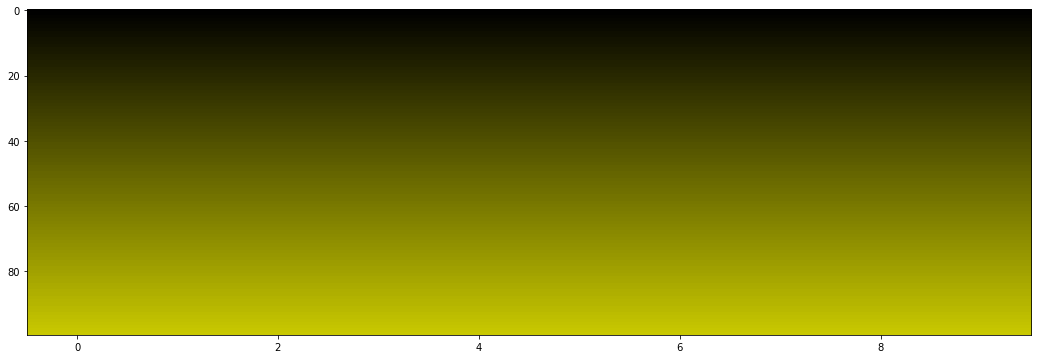

In [105]:
plt.figure()
a=np.outer(np.arange(0,1,0.01),np.ones(10))
fact = 1.0/255.0
cdict2 = {'red':  [(0.0,   0*fact,  0*fact),
                   (0.25, 50*fact, 50*fact),
                   (0.5,  100*fact, 100*fact),
                   (0.75, 150*fact, 150*fact),
                   (1.0,   200*fact,  200*fact)],
         'green': [(0.0,   0*fact,  0*fact),
                   (0.25, 50*fact, 50*fact),
                   (0.5,  100*fact, 100*fact),
                   (0.75, 150*fact, 150*fact),
                   (1.0,   200*fact,  200*fact)],
         'blue':  [(0.0,  0*fact, 0*fact),
                   (0.25, 0*fact, 0*fact),
                   (0.5,  0*fact, 0*fact),
                   (0.75, 0*fact, 0*fact),
                   (1.0,   0*fact,  0*fact)]} 
my_cmap2 = matplotlib.colors.LinearSegmentedColormap('my_colormap2',cdict2,256)
plt.imshow(a,aspect='auto', cmap =my_cmap2)                   
plt.show()

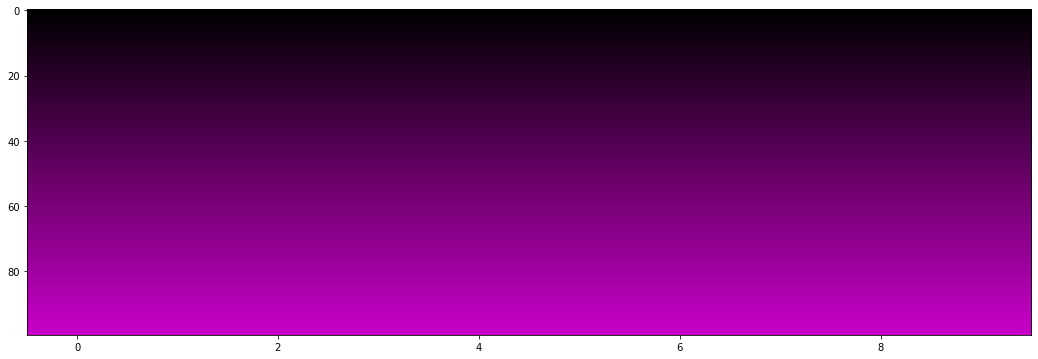

In [106]:
plt.figure()
a=np.outer(np.arange(0,1,0.01),np.ones(10))
fact = 1.0/255.0
cdict2 = {'red':  [(0.0,   0*fact,  0*fact),
                   (0.25, 50*fact, 50*fact),
                   (0.5,  100*fact, 100*fact),
                   (0.75, 150*fact, 150*fact),
                   (1.0,   200*fact,  200*fact)],
         'green': [(0.0,   0*fact,  0*fact),
                   (0.25, 0*fact, 0*fact),
                   (0.5,  0*fact, 0*fact),
                   (0.75, 0*fact, 0*fact),
                   (1.0,   0*fact,  0*fact)],
         'blue':  [(0.0,  0*fact, 0*fact),
                   (0.25, 50*fact, 50*fact),
                   (0.5,  100*fact, 100*fact),
                   (0.75, 150*fact, 150*fact),
                   (1.0,   200*fact,  200*fact)]} 
my_cmap3 = matplotlib.colors.LinearSegmentedColormap('my_colormap2',cdict2,256)
plt.imshow(a,aspect='auto', cmap =my_cmap3)                   
plt.show()

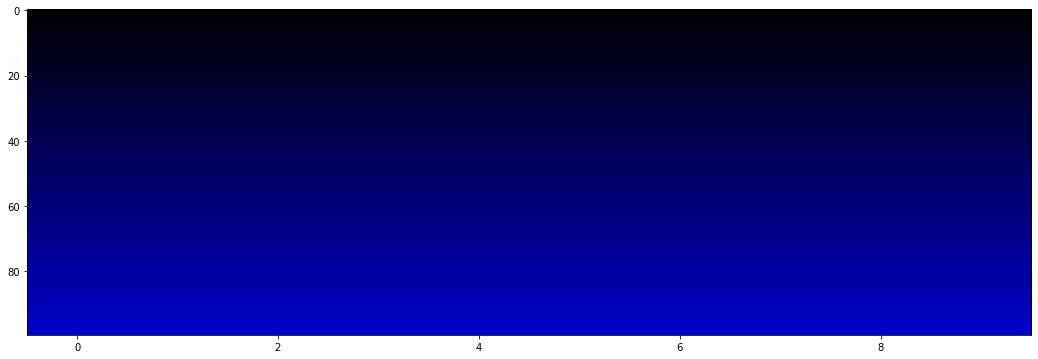

In [107]:
plt.figure()
a=np.outer(np.arange(0,1,0.01),np.ones(10))
fact = 1.0/255.0
cdict2 = {'red':  [(0.0,   0*fact,  0*fact),
                   (0.25, 0*fact, 0*fact),
                   (0.5,  0*fact, 0*fact),
                   (0.75, 0*fact, 0*fact),
                   (1.0,   0*fact,  0*fact)],
         'green': [(0.0,   0*fact,  0*fact),
                   (0.25, 0*fact, 0*fact),
                   (0.5,  0*fact, 0*fact),
                   (0.75, 0*fact, 0*fact),
                   (1.0,   0*fact,  0*fact)],
         'blue':  [(0.0,  0*fact, 0*fact),
                   (0.25, 50*fact, 50*fact),
                   (0.5,  100*fact, 100*fact),
                   (0.75, 150*fact, 150*fact),
                   (1.0,   200*fact,  200*fact)]} 
my_cmap4 = matplotlib.colors.LinearSegmentedColormap('my_colormap2',cdict2,256)
plt.imshow(a,aspect='auto', cmap =my_cmap4)                   
plt.show()

## Plotting ensemble model results

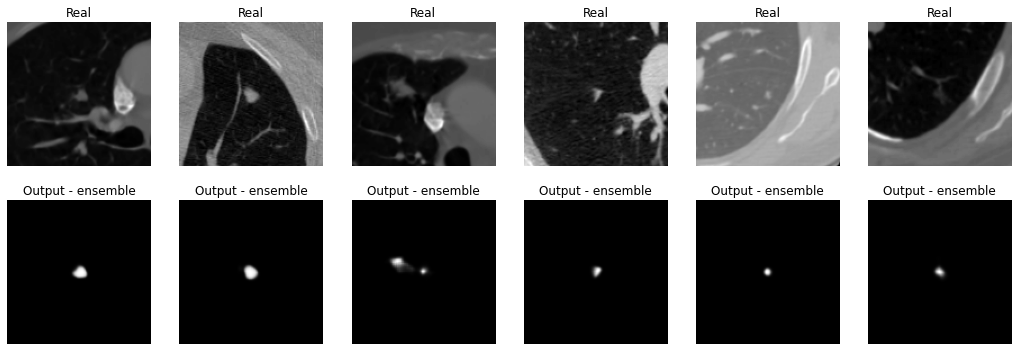

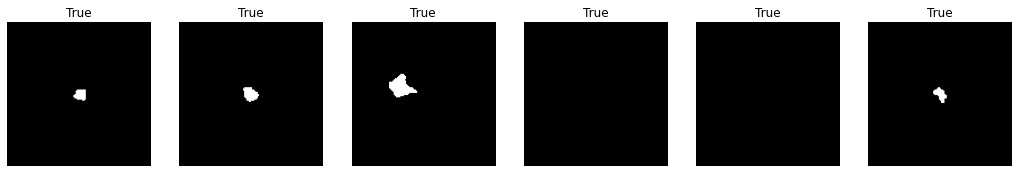

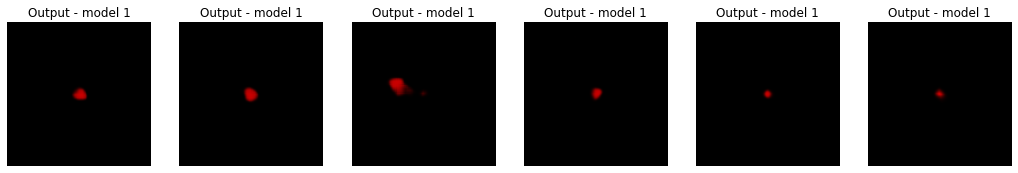

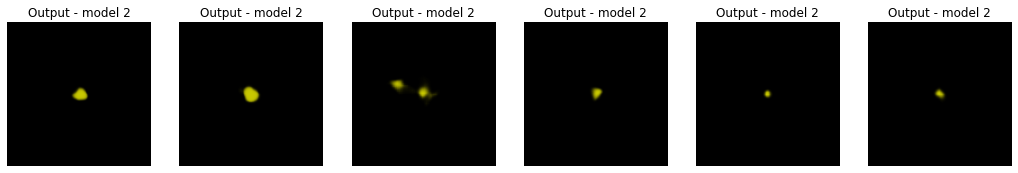

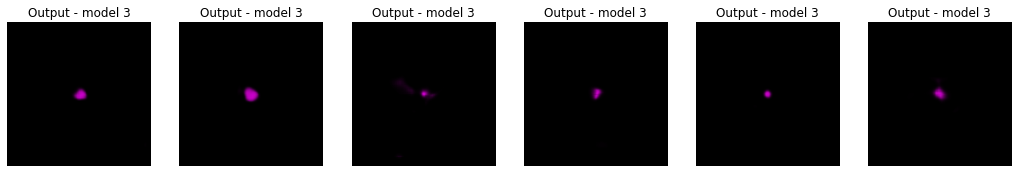

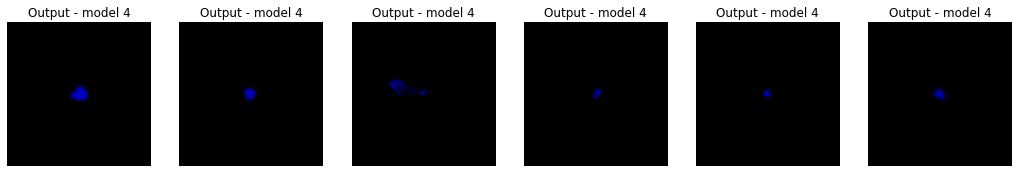

In [115]:
epoch=1
epochs=1
plt.figure(1) 
for k in range(6):
    plt.subplot(2, 6, k+1)
    plt.imshow(X_val[k].numpy(),cmap='gray')
    plt.title('Real')
    plt.axis('off')

    plt.subplot(2, 6, k+7)
    plt.imshow(Y_hat[k,0], cmap='gray')
    plt.title('Output - ensemble')
    plt.axis('off')

    
plt.show()


for k in range(6):            
      plt.subplot(2, 6, k+1)
      plt.imshow(Y_val[k], cmap='gray')
      plt.title('True')
      plt.axis('off')
        
plt.show()


for k in range(6):    
    plt.subplot(1, 6, k+1)
    plt.imshow(Y_hat_m1[k,0], cmap=my_cmap1)
    plt.title('Output - model 1')
    plt.axis('off')
plt.show()

for k in range(6):    
    plt.subplot(1, 6, k+1)
    plt.imshow(Y_hat_m2[k,0], cmap=my_cmap2)
    plt.title('Output - model 2')
    plt.axis('off')
plt.show()

for k in range(6):    
    plt.subplot(1, 6, k+1)
    plt.imshow(Y_hat_m3[k,0], cmap=my_cmap3)
    plt.title('Output - model 3')
    plt.axis('off')
plt.show()

for k in range(6):    
    plt.subplot(1, 6, k+1)
    plt.imshow(Y_hat_m4[k,0], cmap=my_cmap4)
    plt.title('Output - model 4')
    plt.axis('off')
plt.show()



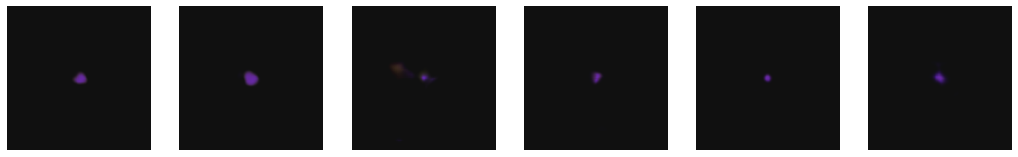

In [116]:
for k in range(6):    
    plt.subplot(1, 6, k+1)
    plt.imshow(Y_hat_m1[k,0], cmap=my_cmap1,alpha=0.5)
    plt.imshow(Y_hat_m2[k,0], cmap=my_cmap2,alpha=0.5)
    plt.imshow(Y_hat_m3[k,0], cmap=my_cmap3,alpha=0.5)
    plt.imshow(Y_hat_m3[k,0], cmap=my_cmap4,alpha=0.5)
    #plt.imshow(Y_hat_m1[k,0], cmap=my_cmap1,alpha=0.25)
    #plt.imshow(Y_hat_m2[k,0], cmap=my_cmap2,alpha=0.25)
    #plt.imshow(Y_hat_m3[k,0], cmap=my_cmap3,alpha=0.25)
    #plt.imshow(Y_hat_m3[k,0], cmap=my_cmap4,alpha=0.25)
    #plt.title('Output - ambiguity')
    plt.axis('off')
plt.show()

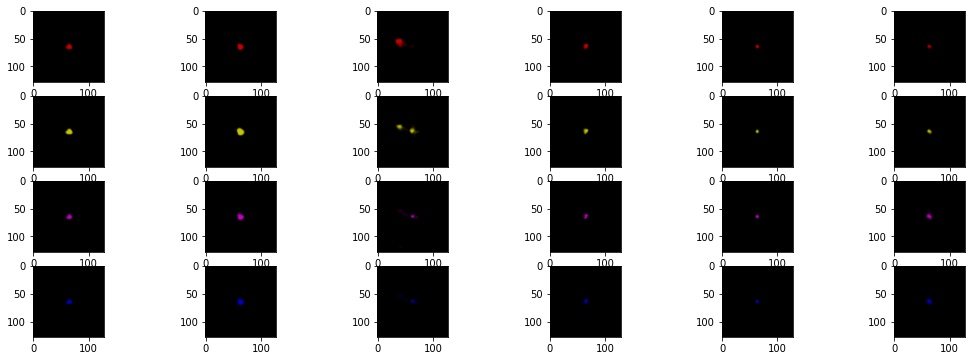

In [112]:
for k in range(6):    
    plt.subplot(4, 6, k+1)
    
    plt.imshow(Y_hat_m1[k,0], cmap=my_cmap1)
    plt.subplot(4, 6, k+7)
    plt.imshow(Y_hat_m2[k,0], cmap=my_cmap2)
    plt.subplot(4, 6, k+13)
    plt.imshow(Y_hat_m3[k,0], cmap=my_cmap3)
    plt.subplot(4, 6, k+19)
    plt.imshow(Y_hat_m3[k,0], cmap=my_cmap4)
    #plt.title('Output - ambiguity')
    #plt.axis('off')
plt.show()

## Test loss and performance for ensemble model

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:54: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


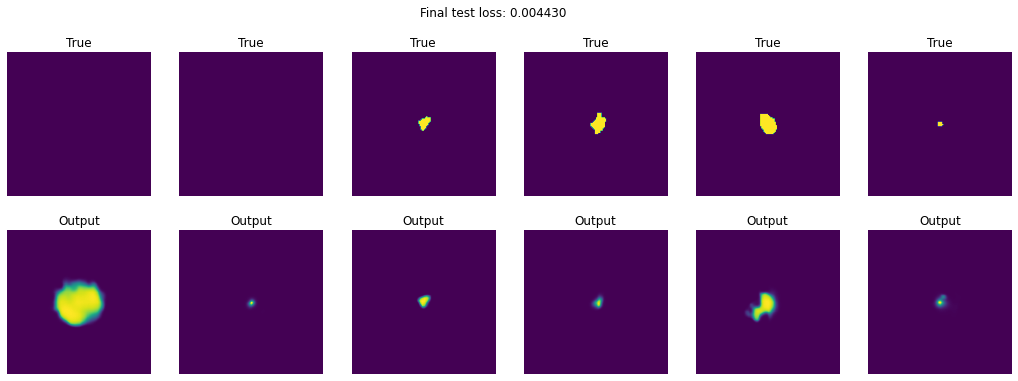

In [42]:
model.eval()
avg_loss = 0
model.train()  # train mode
for X_batch, Y_batch in data_ts:
    X_batch = X_batch.to(device)
    Y_batch = Y_batch.to(device)

    # set parameter gradients to zero
    #opt.zero_grad()

    # forward
    Y_pred = model(X_batch.unsqueeze(1)) #oprdindeligt havde vi 3 lag (RGB), nu har vi kun 1 (greyscale) -> 
    loss = bce_loss_positive(Y_batch.unsqueeze(1), Y_pred)  # forward-pass
    #loss.backward()  # backward-pass
    #opt.step()  # update weights

    # calculate metrics to show the user
    avg_loss += loss / len(data_tr)
print(' - loss: %f' % avg_loss)




# show intermediate results
model.eval()  # testing mode
Y_hat = F.sigmoid(model(X_batch.to(device).unsqueeze(1))).detach().cpu()
print(Y_hat.shape)
clear_output(wait=True)

plt.figure(1)
for k in range(6):
    plt.subplot(2, 6, k+1)
    plt.imshow(X_batch[k].cpu().numpy())
    plt.title('Real')
    plt.axis('off')

    plt.subplot(2, 6, k+7)
    plt.imshow(Y_hat[k,0])
    
    plt.title('Output')
    plt.axis('off')

plt.suptitle('Final test loss: %f' % ( avg_loss))
#plt.show()



for k in range(6):
    plt.subplot(2, 6, k+1)
    plt.imshow(Y_batch[k].cpu().numpy())
    plt.title('True')
    plt.axis('off')

plt.show()


In [44]:
#calculate_performance_no_T(model,data_tr,5)
#calculate_performance_no_T(model,data_val,5)
calculate_performance_no_T(model,data_ts,50)

##############################
Threshold is: 0.1


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


-------Confusion matrix--------
[[4869458   17556]
 [   8143   20043]]
-------------------------------
Accuracy score: 0.9947715250651041
Sensitivity 0.7110977080820265
Specificity 0.9964076223231609
IoU is 0.30467431785361404
Dice overlap is: 0.6093486357072281
##############################
##############################
Threshold is: 0.3
-------Confusion matrix--------
[[4878803    8545]
 [  11695   16157]]
-------------------------------
Accuracy score: 0.9958821614583333
Sensitivity 0.5801019675427258
Specificity 0.9982516080295489
IoU is 0.3074361609011683
Dice overlap is: 0.6148723218023366
##############################
##############################
Threshold is: 0.5
-------Confusion matrix--------
[[4884862    7116]
 [   8037   15185]]
-------------------------------
Accuracy score: 0.9969171142578125
Sensitivity 0.6539057790026699
Specificity 0.9985453736709364
IoU is 0.3335676471234321
Dice overlap is: 0.6671352942468642
##############################
######################